In [1]:
import pickle
import torch
import torchvision.models as models
import os
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, Birch
import matplotlib.pyplot as plt
from fairis_tools.experiment_tools.place_cell.PlaceCellLibrary import *

os.chdir("../../..")
print(os.getcwd())

/Users/titonka/FAIRIS


In [2]:
with open("data/GeneratedPCNetworks/VisualPlaceCellData/birch_centers",'rb') as file:
    cluster_centers = pickle.load(file)
# with open("data/VisualPlaceCellData/LM8_1000",'rb') as file:
#     data = pickle.load(file)

In [4]:
# Load pre-trained ResNet50 model and remove classification layers for feature extraction
resnet50 = models.resnet50(pretrained=True)
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-2])  # Remove the fully connected layers
resnet50.eval()  # Set model to evaluation mode


# Function to process a single image and extract features, with additional landmark and orientation data
def process_datapoint(image_tensor, landmarks_binary_list, orientation_radians):
    """
    Process a single image tensor through ResNet50, and augment the features with
    the binary list of detected landmarks and the robot's orientation.

    Args:
    - image_tensor (torch.Tensor): The image tensor from Webots camera.
    - landmarks_binary_list (list of int): Binary list indicating which landmarks are detected in the image.
    - orientation_radians (float): The robot's orientation in radians from the IMU.

    Returns:
    - full_features (numpy array): The combined feature vector from ResNet50, landmarks, and orientation.
    """
    with torch.no_grad():
        # Extract ResNet50 features
        features = resnet50(image_tensor.unsqueeze(0))  # Add batch dimension (unsqueeze adds a batch dimension)
        flattened_features = features.view(features.size(0), -1)  # Flatten to [1, 2048 * 7 * 7]
        flattened_features = flattened_features.cpu().numpy().squeeze()  # Convert to NumPy array and remove extra dimensions

    # Convert the binary landmark list and orientation to a NumPy array
    landmarks_and_orientation = np.array(landmarks_binary_list + [orientation_radians], dtype=np.float32)

    # Concatenate the ResNet features with the landmarks and orientation
    full_features = np.concatenate((flattened_features, landmarks_and_orientation))

    return full_features


# Function to extract features from each datapoint, including landmarks and orientation
def extract_features_with_landmarks_and_orientation(dataset):
    """
    Extract features from the dataset one by one, augmenting with landmarks and orientation.

    Args:
    - dataset (PovDataset): The dataset containing Datapoint objects.

    Returns:
    - features_list (list of numpy arrays): A list of feature vectors for each image in the dataset.
    - xy_labels (list of tuples): A list of (x, y) coordinates corresponding to each feature vector.
    """
    features_list = []
    xy_labels = []
    count = 1
    # Process each datapoint individually
    for datapoint in dataset.data:
        print("Processing data point: ", count)
        count += 1
        # Extract landmarks and orientation (simulated here as placeholders, replace with actual values)
        landmarks_binary_list = datapoint.landmark_mask  # Assume this is part of your dataset
        orientation_radians = datapoint.theta  # Assume this is part of your dataset

        # Extract features from the image tensor, and include the landmarks and orientation
        features = process_datapoint(datapoint.image_tensor, landmarks_binary_list, orientation_radians)
        features_list.append(features)

        # Keep track of the (x, y) coordinates
        xy_labels.append((datapoint.x, datapoint.y))

    return features_list, xy_labels

# features, xy_list = extract_features_with_landmarks_and_orientation(data)

/Users/titonka/FAIRIS/fairis_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/titonka/FAIRIS/fairis_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing data point:  1
Processing data point:  2
Processing data point:  3
Processing data point:  4
Processing data point:  5
Processing data point:  6
Processing data point:  7
Processing data point:  8
Processing data point:  9
Processing data point:  10
Processing data point:  11
Processing data point:  12
Processing data point:  13
Processing data point:  14
Processing data point:  15
Processing data point:  16
Processing data point:  17
Processing data point:  18
Processing data point:  19
Processing data point:  20
Processing data point:  21
Processing data point:  22
Processing data point:  23
Processing data point:  24
Processing data point:  25
Processing data point:  26
Processing data point:  27
Processing data point:  28
Processing data point:  29
Processing data point:  30
Processing data point:  31
Processing data point:  32
Processing data point:  33
Processing data point:  34
Processing data point:  35
Processing data point:  36
Processing data point:  37
Processing

In [16]:
class VisiualPlaceCell:
    def __init__(self, pc_id, center_point, sigma):
        self.id = pc_id
        self.center_point = center_point
        self.sigma = sigma
        self.activity = 0.0

    def calculate_activation(self,robot_point):
        distance = np.linalg.norm(self.center_point - robot_point)
        self.activity = np.exp(-(distance**2) / (2*self.sigma**2))

class VisualPlaceCellNetwork:
    def __init__(self):
        self.pc_network = None
        self.pc_list = []
        self.pc_coordinates = []

    def add_pc_to_network(self, robot_point, radius=.1):
        pc_id = len(self.pc_list)
        self.pc_list.append(VisiualPlaceCell(pc_id, robot_point, radius))
        self.pc_coordinates.append(robot_point)
        self.pc_network = KDTree(self.pc_coordinates)

    def get_num_active_pc(self, robot_point, search_radius=.5):
        if self.pc_network is not None:
            return self.pc_network.query_radius([robot_point], r=search_radius, count_only=True)[0]
        else:
            return 0

    def calculate_single_pc_activation(self, pc, robot_point):
        pc.calculate_activation(robot_point)

    def activate_pc_network(self, robot_point):
        # Standard approach
        for pc in self.pc_list:
            pc.calculate_activation(robot_point)
        self.normilize_all_pc()
    def get_total_pc_activation(self):
        total_activation = 0
        for pc in self.pc_list:
            total_activation += pc.activity
        return total_activation

    def get_all_pc_activations_normalized(self, robot_point):
        self.activate_pc_network(robot_point)
        self.normilize_all_pc()
        return np.array([pc.activity for pc in self.pc_list], dtype=np.float32)

    def print_pc_activations(self):
        for pc in self.pc_list:
            print(pc.id, pc.activity)

    def normilize_all_pc(self):
        total_activation = self.get_total_pc_activation()
        if total_activation == 0:
            total_activation = 1
        for pc in self.pc_list:
            pc.activity = pc.activity / total_activation

In [3]:
pc_network = VisualPlaceCellNetwork()
for center in cluster_centers:
    pc_network.add_pc_to_network(center,radius = 250)
    

In [4]:
with open("data/GeneratedPCNetworks/VisualPlaceCells/birch_pc",'wb') as file:
    pickle.dump(pc_network,file)

In [44]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def plot_place_cell_activity(index):
    """
    Plot the x, y location of the data point and the corresponding place cell activations.
    
    Args:
    - index (int): The index of the selected data point.
    """
    # Get the x, y location of the selected data point
    x, y = xy_list[index]
    dx = 0.45 * np.cos(features[index][-1])
    dy = 0.45 * np.sin(features[index][-1])
    
    
    # Get the place cell activations for the selected data point
    pc_network.activate_pc_network(features[index])
    activations = pc_network.get_all_pc_activations_normalized(features[index])

    # Create two subplots: one for x, y location and one for place cell activations
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the x, y location on the first subplot
    ax[0].quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='r')
    ax[0].scatter(x, y, color='blue', s=50, zorder=5)
    ax[0].set_xlim(-3.5, 3.5)
    ax[0].set_ylim(-3.5, 3.5)
    ax[0].set_title(f"x, y Location of Data Point {index}")
    ax[0].set_xlabel("X Coordinate")
    ax[0].set_ylabel("Y Coordinate")

    # Plot the place cell activations on the second subplot
    ax[1].bar(range(18), activations, color='red')
    ax[1].set_title(f"Place Cell Activations for Data Point {index}")
    ax[1].set_xlabel("Place Cell")
    ax[1].set_xticks(range(18))
    ax[1].set_xticklabels(range(18)) 
    ax[1].set_ylabel("Activation Level")
    
    # Show the plots
    plt.show()

# Create an interactive slider for selecting the index of the data point
# interact(plot_place_cell_activity, index=IntSlider(min=0, max=999, step=1, value=0))

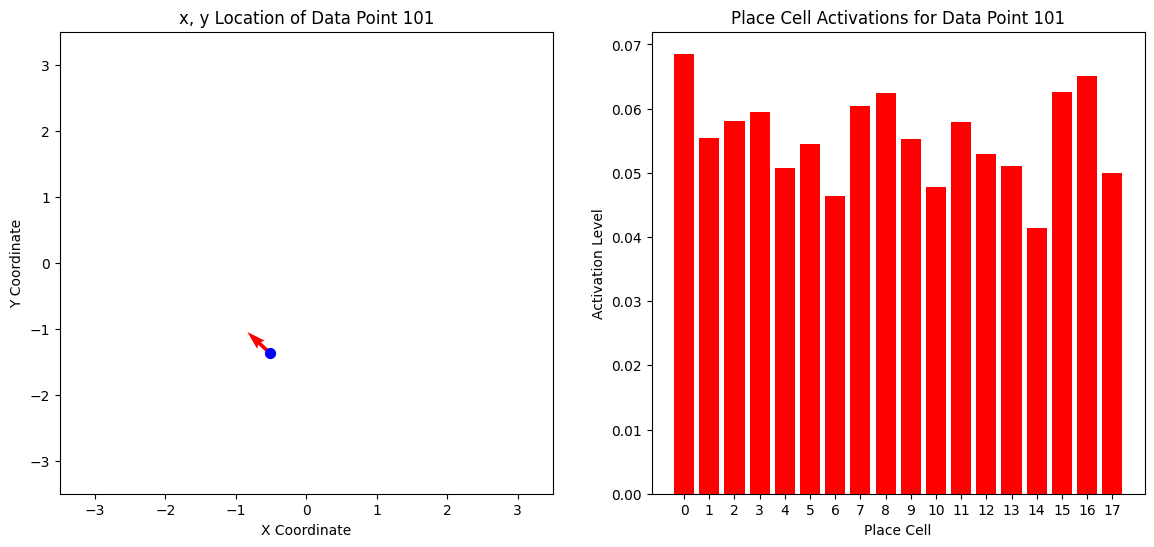

In [47]:
plot_place_cell_activity(101)

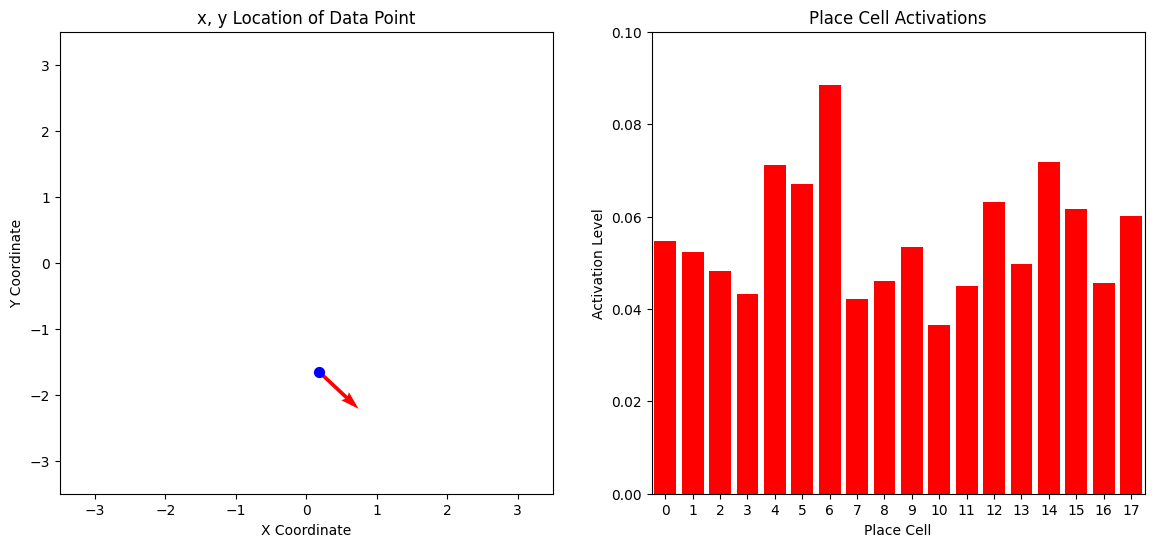

In [56]:
from matplotlib.animation import FuncAnimation

# Assuming pc_network, xy_list, and features are defined elsewhere
n_samples = 100  # Number of data points
n_place_cells = 18  # Number of place cells

# Create the figure and axes for the animation
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Initial plot settings
ax[0].set_xlim(-3.5, 3.5)
ax[0].set_ylim(-3.5, 3.5)
ax[0].set_xlabel("X Coordinate")
ax[0].set_ylabel("Y Coordinate")
ax[0].set_title("x, y Location of Data Point")

ax[1].set_title("Place Cell Activations")
ax[1].set_xlabel("Place Cell")
ax[1].set_xticks(range(n_place_cells))
ax[1].set_xlim(-0.5, n_place_cells - 0.5)  # Adjust x limits to avoid clipping
ax[1].set_ylabel("Activation Level")

# Quiver (vector) and scatter (dot) for the location plot
quiver = ax[0].quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=1, color='r')  # Initialize with 0
dot = ax[0].scatter(0, 0, color='blue', s=50, zorder=5)  # Initialize with 0

# Bar plot for the place cell activations
bars = ax[1].bar(range(n_place_cells), [0] * n_place_cells, color='red')

# Function to initialize the plot (sets up the background for the animation)
def init():
    quiver.set_offsets([0, 0])  # Reset vector position with dummy coordinates
    dot.set_offsets([0, 0])     # Reset dot position with dummy coordinates
    for bar in bars:
        bar.set_height(0)         # Reset the bar heights to 0
    return quiver, dot, *bars

# Function to update the plot for each frame (i.e., for each data point)
def update(frame):
    # Get the x, y location and orientation of the selected data point
    x, y = xy_list[frame]
    theta = features[frame][-1]
    dx = 0.8 * np.cos(theta)  # Increase the length of the vector to make it more visible
    dy = 0.8 * np.sin(theta)
    
    # Get the place cell activations for the selected data point
    pc_network.activate_pc_network(features[frame])
    activations = pc_network.get_all_pc_activations_normalized(features[frame])

    # Update the quiver (vector) and scatter (dot) for the x, y location
    quiver.set_offsets([x, y])
    quiver.set_UVC(dx, dy)
    dot.set_offsets([x, y])

    # Update the bar plot for place cell activations
    for bar, activation in zip(bars, activations):
        bar.set_height(activation)

    # Adjust the y-axis limit of the bar plot to be slightly above the maximum activation
    ax[1].set_ylim(0, .1) 

    return quiver, dot, *bars

# Create the animation
ani = FuncAnimation(fig, update, frames=range(n_samples), init_func=init, blit=True, repeat=False)

# Save the animation as a movie (MP4 format)
ani.save("data/videos/place_cell_activity_animation.mp4", writer='ffmpeg', fps=2)
